# Misquonceptions

In [135]:
# install necessary libs
#%pip install qiskit qiskit-aer qiskit-optimization qiskit-algorithms  
#%pip install qiskit_ibm_runtime
import warnings
warnings.filterwarnings('ignore')

In [136]:
import math
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
import time

firstBinaryNumber = "1010"
secondBinaryNumber = "110"
start = time.time()

if len(firstBinaryNumber) < len(secondBinaryNumber):
    firstBinaryNumber, secondBinaryNumber = secondBinaryNumber, firstBinaryNumber

secondBinaryNumber = "0" * (len(firstBinaryNumber) - len(secondBinaryNumber)) + secondBinaryNumber
maxInputLength = len(firstBinaryNumber)

regA = QuantumRegister(maxInputLength, "regA")
regB = QuantumRegister(maxInputLength+1, "regB")
regC = ClassicalRegister(maxInputLength + 1, "regC")
qc = QuantumCircuit(regA, regB, regC, name="qc")

#qc.draw("mpl")


for idx, val in enumerate(firstBinaryNumber):
    if val == "1":
        qc.x(regA[maxInputLength - (idx + 1)])
for idx, val in enumerate(secondBinaryNumber):
    if val == "1":
        qc.x(regB[maxInputLength - (idx + 1)])
#qc.draw("mpl")


for target in range(maxInputLength, -1, -1):
    qc.h(regB[target])
    for control in range(target-1, -1, -1):
        qc.cp(math.pi*(2**(control-target)), regB[target], regB[control])
qc.barrier()
#qc.draw("mpl", plot_barriers=False)


for target in range(maxInputLength):
    for control in range(maxInputLength + 1 - target):
        lam = math.pi / (2**control)
        qc.cp(lam, regA[target], regB[target+control])
qc.barrier()
#qc.draw("mpl", plot_barriers=False)


for target in range(maxInputLength + 1):
    qc.h(regB[target])
    for control in range(target+1, maxInputLength + 1):
        qc.cp(-math.pi/(2**(control-target)), regB[control], regB[target])
qc.measure_all()


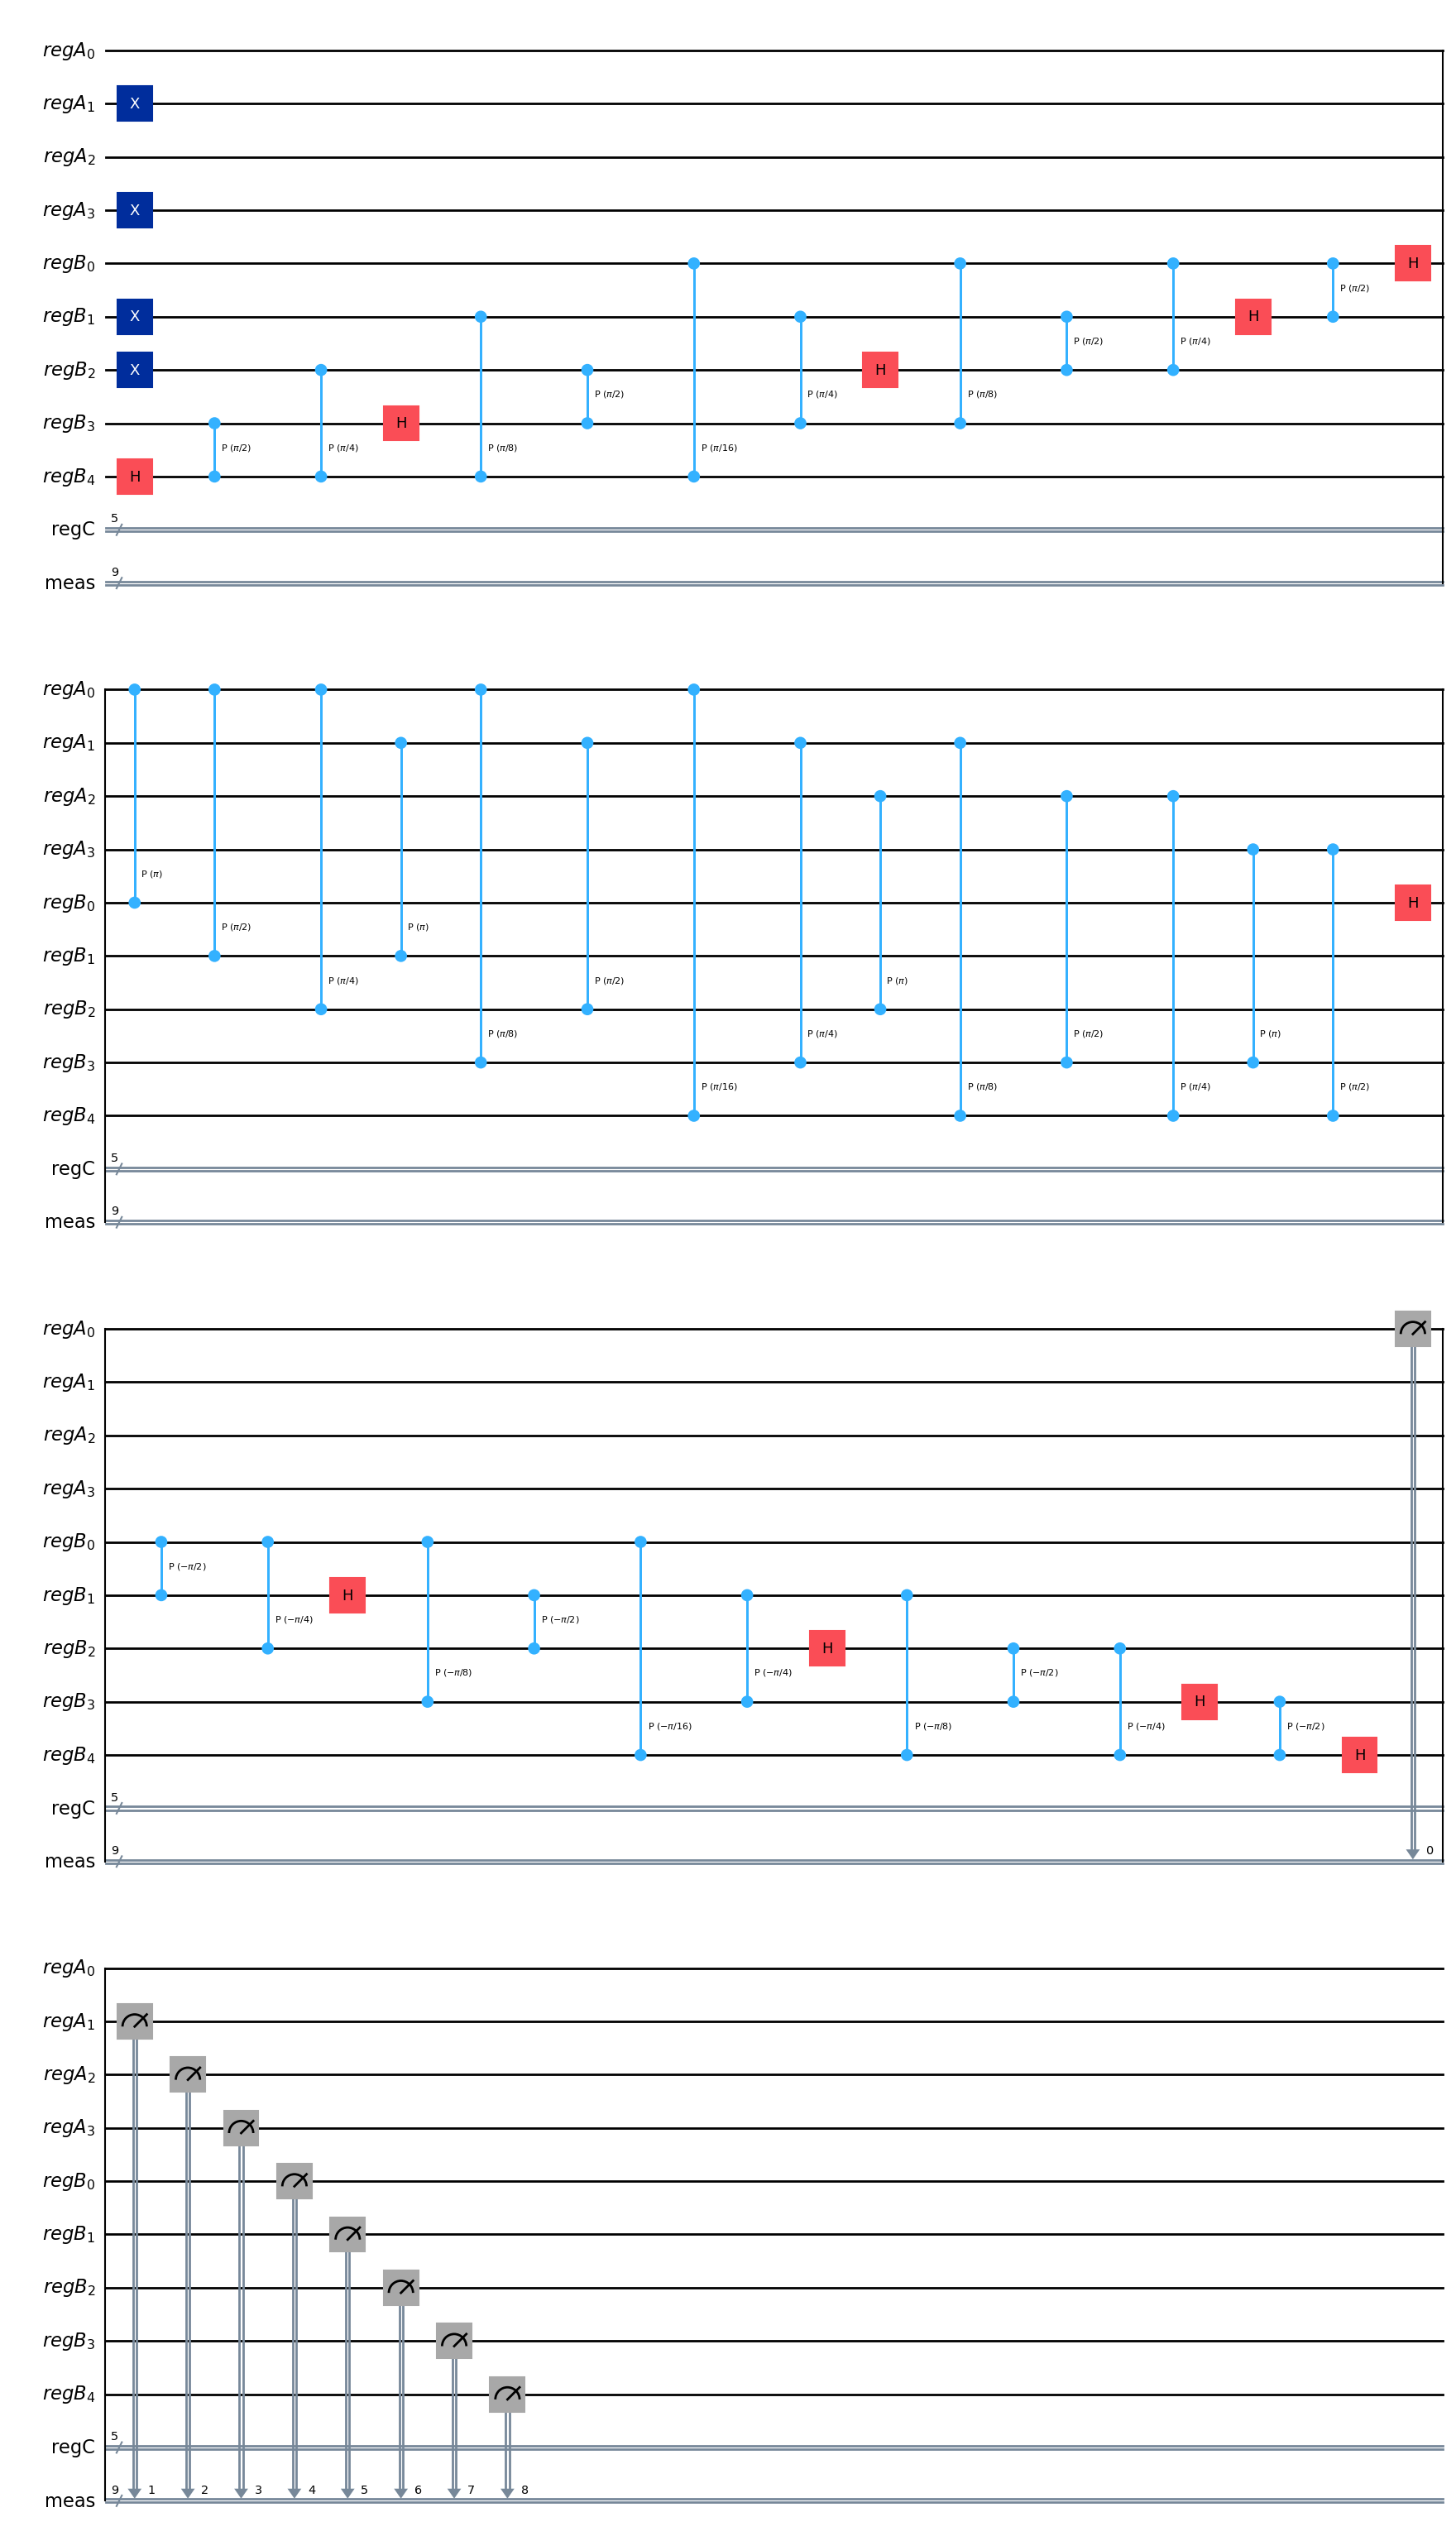

In [137]:
qc.draw(output='mpl', plot_barriers=False)

In [144]:
# Account connection
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
token="Input your token here"

# for problems with connection
#QiskitRuntimeService.delete_account()
QiskitRuntimeService.save_account(channel="ibm_quantum",token=token,overwrite=True)

In [139]:
# connect to IBM

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

"""
# For simulator use: 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2 # lot of fake providers
backend = FakeAlmadenV2()
# also comment backend above
"""

pm =generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit =pm.run(qc)

In [140]:
# Version

print(
    f"Name: {backend.name}\n",
    f"Version: {backend.version}\n",
    f"No of qubits: {backend.num_qubits}\n"
)

Name: ibm_brisbane
 Version: 2
 No of qubits: 127



In [141]:
# run on QM
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1000
job = sampler.run([isa_circuit])
print(f"Job ID is: {job.job_id()}")
pub_result = job.result()[0]

Job ID is: d19ybtfmya70008n36yg


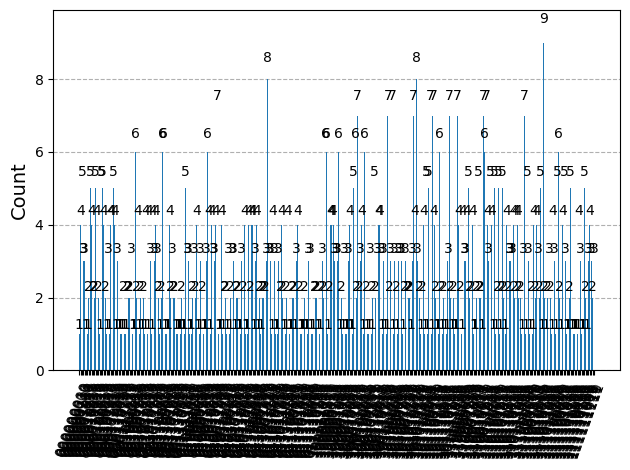

In [143]:
# visualize data
from qiskit.visualization import plot_histogram

#print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")
plot_histogram(pub_result.data.meas.get_counts())